In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For astronomical data
from astropy.table import Table
import lightkurve as lk

# Configure visualization
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("🌟 K2 Dataset Processing Pipeline")
print("📊 Libraries loaded successfully!")

🌟 K2 Dataset Processing Pipeline
📊 Libraries loaded successfully!


c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


# 🌟 K2 Dataset Processing Pipeline for Exoplanet Classification

This notebook processes the K2 dataset following the same comprehensive structure as the Kepler dataset, but adapted for K2-specific features and disposition classes.

## Dataset Overview
- **Source**: NASA K2 Mission (Extended Kepler Mission) 
- **Target Variable**: `disposition` (Archive Disposition)
- **Classes**: CONFIRMED, CANDIDATE, FALSE POSITIVE
- **Features**: K2-specific planetary and stellar parameters

## Output Structure
All K2 outputs will be saved in dedicated subdirectories for unique identification:
- **Processed Data**: `data/processed/k2/`
- **ML Artifacts**: `artifacts/k2/`

## 1. Data Loading and Initial Exploration

In [2]:
# Load K2 dataset
k2_df = pd.read_csv('k2_dataset.csv', comment='#', low_memory=False)

print("📊 K2 Dataset Basic Information:")
print(f"Shape: {k2_df.shape}")
print(f"Columns: {k2_df.columns.tolist()[:10]}...") # Show first 10 columns
print("\n🎯 Target Variable Distribution:")
print(k2_df['disposition'].value_counts())
print(f"\n✨ Total samples: {len(k2_df)}")
print(f"🔢 Total features: {k2_df.shape[1]}")

# Display first few rows
print("\n📋 First 3 rows:")
k2_df.head(3)

📊 K2 Dataset Basic Information:
Shape: (3992, 295)
Columns: ['rowid', 'pl_name', 'hostname', 'pl_letter', 'k2_name', 'epic_hostname', 'epic_candname', 'hd_name', 'hip_name', 'tic_id']...

🎯 Target Variable Distribution:
disposition
CONFIRMED         2308
CANDIDATE         1369
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

✨ Total samples: 3992
🔢 Total features: 295

📋 First 3 rows:


,rowid,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,...,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-02-15,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2016-07-28,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,...,2018-04-26,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Check data types and missing values
print("🔍 Data Types Summary:")
print(f"Numeric columns: {k2_df.select_dtypes(include=[np.number]).shape[1]}")
print(f"Object columns: {k2_df.select_dtypes(include=['object']).shape[1]}")

print("\n📊 Missing Values Analysis:")
missing_counts = k2_df.isnull().sum()
missing_pct = (missing_counts / len(k2_df)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

print(f"Columns with missing values: {(missing_counts > 0).sum()}")
print(f"Columns with >50% missing: {(missing_pct > 50).sum()}")
print(f"Columns with >90% missing: {(missing_pct > 90).sum()}")

# Show most missing columns
print("\n🚨 Top 10 columns with missing values:")
missing_summary.head(10)

🔍 Data Types Summary:
Numeric columns: 262
Object columns: 33

📊 Missing Values Analysis:
Columns with missing values: 289
Columns with >50% missing: 145
Columns with >90% missing: 77

🚨 Top 10 columns with missing values:


,Missing_Count,Missing_Percentage
pl_occdeperr1,3992,100.000000
sy_kepmagerr2,3992,100.000000
sy_icmagerr1,3992,100.000000
sy_kepmagerr1,3992,100.000000
sy_icmag,3992,100.000000
pl_occdeperr2,3992,100.000000
sy_icmagerr2,3992,100.000000
pl_occdeplim,3991,99.974950
pl_occdep,3991,99.974950
pl_trueobliq,3982,99.749499


## 2. K2-Specific Data Cleaning and Feature Selection

In [4]:
# Define K2-specific features for exoplanet classification
# Following similar categories as Kepler but adapted for K2 data structure

# Planetary orbital and physical parameters
planetary_features = [
    'pl_orbper',        # Orbital Period
    'pl_orbsmax',       # Semi-Major Axis  
    'pl_rade',          # Planet Radius (Earth radii)
    'pl_masse',         # Planet Mass (Earth masses)
    'pl_radj',          # Planet Radius (Jupiter radii) 
    'pl_massj',         # Planet Mass (Jupiter masses)
    'pl_dens',          # Planet Density
    'pl_orbeccen',      # Orbital Eccentricity
    'pl_insol',         # Insolation Flux
    'pl_eqt',           # Equilibrium Temperature
    'pl_orbincl',       # Orbital Inclination
    'pl_tranmid',       # Transit Midpoint
    'pl_imppar',        # Impact Parameter
    'pl_trandep',       # Transit Depth
    'pl_trandur',       # Transit Duration
    'pl_ratdor',        # Planet-Star Distance Ratio
    'pl_ratror',        # Planet-Star Radius Ratio
]

# Stellar parameters
stellar_features = [
    'st_teff',          # Stellar Effective Temperature
    'st_rad',           # Stellar Radius
    'st_mass',          # Stellar Mass
    'st_met',           # Stellar Metallicity
    'st_lum',           # Stellar Luminosity
    'st_logg',          # Stellar Surface Gravity
    'st_age',           # Stellar Age
    'st_dens',          # Stellar Density
    'st_vsin',          # Stellar Rotation Velocity
    'st_rotp',          # Stellar Rotation Period
    'st_radv',          # Stellar Radial Velocity
]

# System and observational parameters
system_features = [
    'sy_pm',            # Proper Motion
    'sy_pmra',          # Proper Motion RA
    'sy_pmdec',         # Proper Motion Dec
    'sy_dist',          # Distance
    'sy_plx',           # Parallax
    'glat',             # Galactic Latitude
    'glon',             # Galactic Longitude
]

# Photometric magnitudes
magnitude_features = [
    'sy_bmag', 'sy_vmag', 'sy_jmag', 'sy_hmag', 'sy_kmag',
    'sy_umag', 'sy_gmag', 'sy_rmag', 'sy_imag', 'sy_zmag',
    'sy_w1mag', 'sy_w2mag', 'sy_gaiamag', 'sy_tmag', 'sy_kepmag'
]

# Mission-specific features
k2_features = [
    'k2_campaigns_num',  # Number of K2 campaigns
    'default_flag',      # Default parameter set flag
]

# Combine all feature lists
all_features = planetary_features + stellar_features + system_features + magnitude_features + k2_features

print(f"🎯 Selected K2 Features:")
print(f"Planetary features: {len(planetary_features)}")
print(f"Stellar features: {len(stellar_features)}")  
print(f"System features: {len(system_features)}")
print(f"Magnitude features: {len(magnitude_features)}")
print(f"K2-specific features: {len(k2_features)}")
print(f"Total selected features: {len(all_features)}")

# Check which features exist in the dataset
available_features = [f for f in all_features if f in k2_df.columns]
missing_features = [f for f in all_features if f not in k2_df.columns]

print(f"\n✅ Available features: {len(available_features)}")
print(f"❌ Missing features: {len(missing_features)}")
if missing_features:
    print(f"Missing: {missing_features}")

🎯 Selected K2 Features:
Planetary features: 17
Stellar features: 11
System features: 7
Magnitude features: 15
K2-specific features: 2
Total selected features: 52

✅ Available features: 52
❌ Missing features: 0


In [5]:
# Create working dataset with target and available features
features_to_use = ['disposition'] + available_features
k2_working = k2_df[features_to_use].copy()

print(f"🔧 Working dataset shape: {k2_working.shape}")

# Clean target variable - map K2 disposition classes
print("\n🎯 K2 Disposition Mapping:")
print("Original disposition values:")
print(k2_working['disposition'].value_counts())

# Create binary classification (CONFIRMED vs others) and multi-class
k2_working['disposition_binary'] = k2_working['disposition'].map({
    'CONFIRMED': 1,
    'CANDIDATE': 0, 
    'FALSE POSITIVE': 0
}).fillna(0)

k2_working['disposition_multiclass'] = k2_working['disposition'].map({
    'CONFIRMED': 2,
    'CANDIDATE': 1,
    'FALSE POSITIVE': 0
}).fillna(0)

print("\n✅ After mapping:")
print("Binary classes:", k2_working['disposition_binary'].value_counts().to_dict())
print("Multi-classes:", k2_working['disposition_multiclass'].value_counts().to_dict())

# Remove rows with missing target
initial_rows = len(k2_working)
k2_working = k2_working.dropna(subset=['disposition'])
final_rows = len(k2_working)
print(f"\n📊 Removed {initial_rows - final_rows} rows with missing disposition")
print(f"Final dataset shape: {k2_working.shape}")

🔧 Working dataset shape: (3992, 53)

🎯 K2 Disposition Mapping:
Original disposition values:
disposition
CONFIRMED         2308
CANDIDATE         1369
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

✅ After mapping:
Binary classes: {1.0: 2308, 0.0: 1684}
Multi-classes: {2.0: 2308, 1.0: 1369, 0.0: 315}

📊 Removed 0 rows with missing disposition
Final dataset shape: (3992, 55)


## 3. Exploratory Data Analysis (EDA)

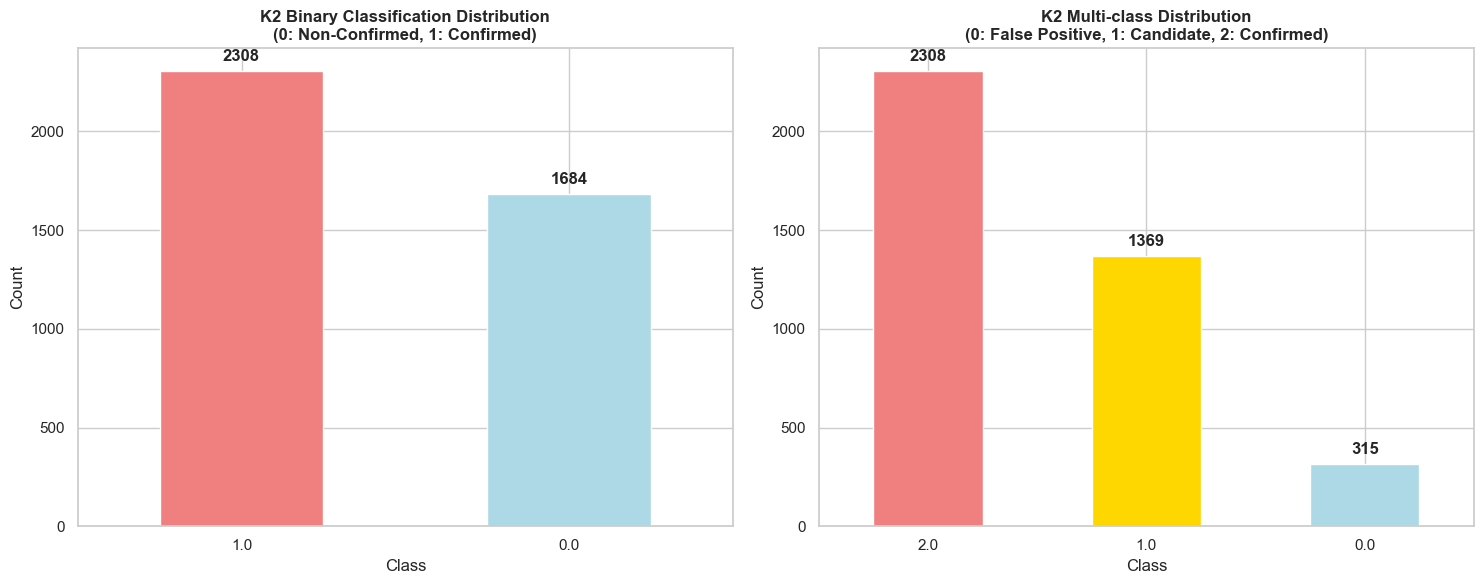

📊 K2 Class Balance Analysis:
Binary - Confirmed: 2308 (57.8%)
Binary - Non-Confirmed: 1684 (42.2%)

Multi - False Positive: 315 (7.9%)
Multi - Candidate: 1369 (34.3%)
Multi - Confirmed: 2308 (57.8%)

⚖️ Imbalance Ratios:
Binary: 1.37:1
Multi-class: 7.33:1


In [6]:
# Class distribution analysis for K2 data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Binary classification distribution
k2_working['disposition_binary'].value_counts().plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightblue'])
axes[0].set_title('K2 Binary Classification Distribution\n(0: Non-Confirmed, 1: Confirmed)', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Add counts on bars
for i, v in enumerate(k2_working['disposition_binary'].value_counts()):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Multi-class distribution  
k2_working['disposition_multiclass'].value_counts().plot(kind='bar', ax=axes[1], 
                                                        color=['lightcoral', 'gold', 'lightblue'])
axes[1].set_title('K2 Multi-class Distribution\n(0: False Positive, 1: Candidate, 2: Confirmed)', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

# Add counts on bars
for i, v in enumerate(k2_working['disposition_multiclass'].value_counts()):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate class balance metrics
binary_counts = k2_working['disposition_binary'].value_counts()
multi_counts = k2_working['disposition_multiclass'].value_counts()

print("📊 K2 Class Balance Analysis:")
print(f"Binary - Confirmed: {binary_counts[1]} ({binary_counts[1]/len(k2_working)*100:.1f}%)")
print(f"Binary - Non-Confirmed: {binary_counts[0]} ({binary_counts[0]/len(k2_working)*100:.1f}%)")
print(f"\nMulti - False Positive: {multi_counts[0]} ({multi_counts[0]/len(k2_working)*100:.1f}%)")
print(f"Multi - Candidate: {multi_counts[1]} ({multi_counts[1]/len(k2_working)*100:.1f}%)")
print(f"Multi - Confirmed: {multi_counts[2]} ({multi_counts[2]/len(k2_working)*100:.1f}%)")

# Check for class imbalance
imbalance_ratio_binary = max(binary_counts) / min(binary_counts) 
imbalance_ratio_multi = max(multi_counts) / min(multi_counts)
print(f"\n⚖️ Imbalance Ratios:")
print(f"Binary: {imbalance_ratio_binary:.2f}:1")
print(f"Multi-class: {imbalance_ratio_multi:.2f}:1")

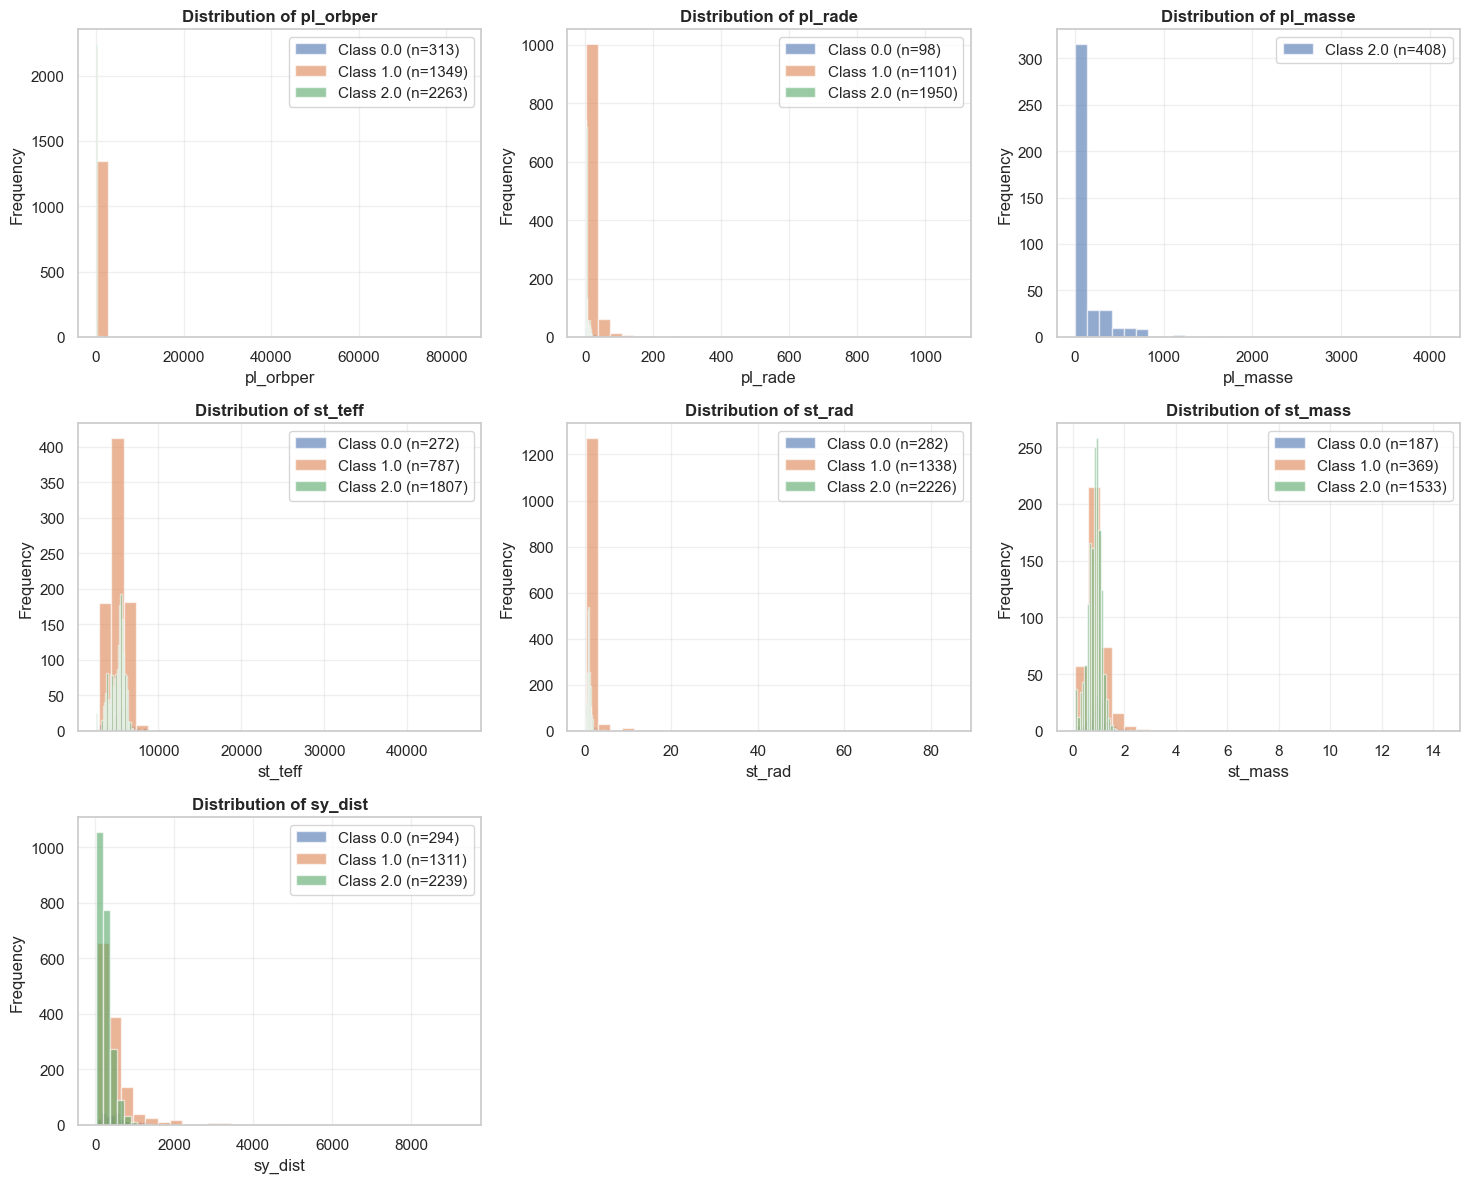

🔍 K2 Feature Distribution Analysis Complete


In [7]:
# Analyze numerical features - K2 specific key parameters
key_k2_features = ['pl_orbper', 'pl_rade', 'pl_masse', 'st_teff', 'st_rad', 'st_mass', 'sy_dist']
available_key_features = [f for f in key_k2_features if f in k2_working.columns and k2_working[f].notna().sum() > 100]

if available_key_features:
    n_features = len(available_key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature in enumerate(available_key_features):
        row, col = i // n_cols, i % n_cols
        
        # Create histogram with disposition overlay
        for disp_class in sorted(k2_working['disposition_multiclass'].unique()):
            data = k2_working[k2_working['disposition_multiclass'] == disp_class][feature].dropna()
            if len(data) > 0:
                axes[row, col].hist(data, alpha=0.6, bins=30, 
                                  label=f'Class {disp_class} (n={len(data)})')
        
        axes[row, col].set_title(f'Distribution of {feature}', fontweight='bold')
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_features, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🔍 K2 Feature Distribution Analysis Complete")
else:
    print("⚠️ Insufficient data for key feature analysis")

## 4. Data Preprocessing and Feature Engineering

In [8]:
# Handle missing values and prepare features for ML
print("🔧 K2 Data Preprocessing Pipeline")

# Select only numerical features for ML (exclude target and identifiers)
exclude_cols = ['disposition', 'disposition_binary', 'disposition_multiclass', 
                'pl_name', 'hostname', 'k2_name', 'epic_hostname', 'epic_candname']

numerical_features = []
for col in k2_working.columns:
    if col not in exclude_cols:
        if k2_working[col].dtype in ['float64', 'int64', 'float32', 'int32']:
            # Only include features with reasonable amount of non-missing data
            missing_pct = k2_working[col].isnull().sum() / len(k2_working) * 100
            if missing_pct < 95:  # Exclude features with >95% missing
                numerical_features.append(col)

print(f"📊 Selected {len(numerical_features)} numerical features for ML")
print(f"Features: {numerical_features[:10]}...") # Show first 10

# Create feature matrix
X_raw = k2_working[numerical_features].copy()
y_binary = k2_working['disposition_binary'].copy()
y_multiclass = k2_working['disposition_multiclass'].copy()

print(f"\n🎯 Feature matrix shape: {X_raw.shape}")
print(f"Binary target distribution: {y_binary.value_counts().to_dict()}")
print(f"Multi-class target distribution: {y_multiclass.value_counts().to_dict()}")

# Handle missing values with median imputation for numerical features
print(f"\n🔍 Missing value handling:")
print(f"Features with missing values: {X_raw.isnull().any().sum()}")

# Fill missing values with median (robust to outliers)
X_filled = X_raw.fillna(X_raw.median())

print(f"After imputation: {X_filled.isnull().sum().sum()} missing values remaining")

# Remove any remaining rows with NaN values
valid_idx = ~(X_filled.isnull().any(axis=1) | y_binary.isnull() | y_multiclass.isnull())
X_clean = X_filled[valid_idx]
y_binary_clean = y_binary[valid_idx] 
y_multiclass_clean = y_multiclass[valid_idx]

print(f"\n✅ Clean dataset shape: {X_clean.shape}")
print(f"Removed {len(X_filled) - len(X_clean)} rows with remaining NaN values")

🔧 K2 Data Preprocessing Pipeline
📊 Selected 50 numerical features for ML
Features: ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_masse', 'pl_radj', 'pl_massj', 'pl_dens', 'pl_orbeccen', 'pl_insol', 'pl_eqt']...

🎯 Feature matrix shape: (3992, 50)
Binary target distribution: {1.0: 2308, 0.0: 1684}
Multi-class target distribution: {2.0: 2308, 1.0: 1369, 0.0: 315}

🔍 Missing value handling:
Features with missing values: 49
After imputation: 0 missing values remaining

✅ Clean dataset shape: (3992, 50)
Removed 0 rows with remaining NaN values


In [9]:
# Feature Engineering - Create K2-specific derived features
print("⚙️ K2 Feature Engineering")

X_engineered = X_clean.copy()

# 1. Planetary characteristics ratios (if available)
if 'pl_rade' in X_engineered.columns and 'pl_masse' in X_engineered.columns:
    # Planet density approximation (mass/radius^3 ratio)
    X_engineered['pl_density_ratio'] = X_engineered['pl_masse'] / (X_engineered['pl_rade'] ** 3 + 1e-8)

if 'pl_radj' in X_engineered.columns and 'pl_rade' in X_engineered.columns:
    # Radius comparison (Jupiter vs Earth radii)
    X_engineered['pl_radius_comparison'] = X_engineered['pl_radj'] / (X_engineered['pl_rade'] + 1e-8)

# 2. Orbital characteristics
if 'pl_orbper' in X_engineered.columns:
    # Log orbital period (periods often log-distributed)
    X_engineered['pl_orbper_log'] = np.log10(X_engineered['pl_orbper'] + 1e-8)

if 'pl_insol' in X_engineered.columns:
    # Log insolation flux
    X_engineered['pl_insol_log'] = np.log10(X_engineered['pl_insol'] + 1e-8)

# 3. Stellar characteristics
if 'st_teff' in X_engineered.columns and 'st_mass' in X_engineered.columns:
    # Stellar temperature to mass ratio
    X_engineered['st_teff_mass_ratio'] = X_engineered['st_teff'] / (X_engineered['st_mass'] + 1e-8)

if 'st_rad' in X_engineered.columns and 'st_mass' in X_engineered.columns:
    # Stellar density approximation
    X_engineered['st_density_approx'] = X_engineered['st_mass'] / (X_engineered['st_rad'] ** 3 + 1e-8)

# 4. System characteristics  
if 'sy_pm' in X_engineered.columns:
    # Log proper motion
    X_engineered['sy_pm_log'] = np.log10(X_engineered['sy_pm'] + 1e-8)

if 'sy_dist' in X_engineered.columns:
    # Log distance
    X_engineered['sy_dist_log'] = np.log10(X_engineered['sy_dist'] + 1e-8)

# 5. Magnitude differences (color indices)
mag_features = [f for f in X_engineered.columns if 'mag' in f and f.startswith('sy_')]
if len(mag_features) >= 2:
    # Create some common color indices if magnitudes are available
    if 'sy_bmag' in X_engineered.columns and 'sy_vmag' in X_engineered.columns:
        X_engineered['color_bv'] = X_engineered['sy_bmag'] - X_engineered['sy_vmag']
    
    if 'sy_jmag' in X_engineered.columns and 'sy_hmag' in X_engineered.columns:
        X_engineered['color_jh'] = X_engineered['sy_jmag'] - X_engineered['sy_hmag']

# Replace any infinite values with NaN and then fill with median
X_engineered = X_engineered.replace([np.inf, -np.inf], np.nan)
X_engineered = X_engineered.fillna(X_engineered.median())

print(f"✅ Feature engineering complete!")
print(f"Original features: {X_clean.shape[1]}")
print(f"Engineered features: {X_engineered.shape[1]}")
print(f"Added {X_engineered.shape[1] - X_clean.shape[1]} new features")

# Show some engineered features
new_features = [col for col in X_engineered.columns if col not in X_clean.columns]
if new_features:
    print(f"New features: {new_features}")

⚙️ K2 Feature Engineering
✅ Feature engineering complete!
Original features: 50
Engineered features: 60
Added 10 new features
New features: ['pl_density_ratio', 'pl_radius_comparison', 'pl_orbper_log', 'pl_insol_log', 'st_teff_mass_ratio', 'st_density_approx', 'sy_pm_log', 'sy_dist_log', 'color_bv', 'color_jh']


## 5. Train-Validation-Test Split and Scaling

In [10]:
# Import required libraries for ML preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import os
import pickle

print("🎯 K2 Dataset Splitting and Scaling")

# Create output directories for K2-specific files
os.makedirs('data/processed/k2', exist_ok=True)
os.makedirs('artifacts/k2', exist_ok=True)

print("📁 Created K2-specific directories")

# Stratified split: 60% train, 20% validation, 20% test
# First split: train vs temp (80% vs 20%)
X_train, X_temp, y_bin_train, y_bin_temp, y_multi_train, y_multi_temp = train_test_split(
    X_engineered, y_binary_clean, y_multiclass_clean,
    test_size=0.4, random_state=42, stratify=y_multiclass_clean
)

# Second split: validation vs test (50% each of temp = 20% each of total)  
X_val, X_test, y_bin_val, y_bin_test, y_multi_val, y_multi_test = train_test_split(
    X_temp, y_bin_temp, y_multi_temp,
    test_size=0.5, random_state=42, stratify=y_multi_temp
)

print(f"📊 K2 Dataset Split Summary:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_engineered)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_engineered)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_engineered)*100:.1f}%)")
print(f"Features: {X_train.shape[1]}")

# Check class distribution in splits
for split_name, y_multi in [('Train', y_multi_train), ('Validation', y_multi_val), ('Test', y_multi_test)]:
    dist = y_multi.value_counts(normalize=True).sort_index()
    print(f"{split_name} distribution: {dist.to_dict()}")

print(f"\n⚖️ Class balance maintained across splits ✅")

🎯 K2 Dataset Splitting and Scaling
📁 Created K2-specific directories
📊 K2 Dataset Split Summary:
Training set: 2395 samples (60.0%)
Validation set: 798 samples (20.0%)
Test set: 799 samples (20.0%)
Features: 60
Train distribution: {0.0: 0.07891440501043841, 1.0: 0.3427974947807933, 2.0: 0.5782881002087683}
Validation distribution: {0.0: 0.07894736842105263, 1.0: 0.3433583959899749, 2.0: 0.5776942355889725}
Test distribution: {0.0: 0.07884856070087609, 1.0: 0.3429286608260325, 2.0: 0.5782227784730913}

⚖️ Class balance maintained across splits ✅


In [11]:
# Apply scaling transformations (same as Kepler pipeline)
print("🔧 Applying Scaling Transformations")

# 1. StandardScaler (z-score normalization)  
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_val_standard = standard_scaler.transform(X_val)
X_test_standard = standard_scaler.transform(X_test)

# 2. MinMaxScaler (0-1 normalization)
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train_standard)
X_val_minmax = minmax_scaler.transform(X_val_standard)  
X_test_minmax = minmax_scaler.transform(X_test_standard)

print("✅ Scaling complete")
print(f"Standard scaling: mean ≈ {X_train_standard.mean():.3f}, std ≈ {X_train_standard.std():.3f}")
print(f"MinMax scaling: min = {X_train_minmax.min():.3f}, max = {X_train_minmax.max():.3f}")

# Convert back to DataFrames with proper column names
feature_names = X_train.columns.tolist()

X_train_scaled = pd.DataFrame(X_train_minmax, columns=feature_names, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_minmax, columns=feature_names, index=X_val.index)  
X_test_scaled = pd.DataFrame(X_test_minmax, columns=feature_names, index=X_test.index)

print(f"📊 Scaled datasets shape:")
print(f"Train: {X_train_scaled.shape}")
print(f"Validation: {X_val_scaled.shape}")
print(f"Test: {X_test_scaled.shape}")

# Calculate class weights for imbalanced classes
class_weights_binary = compute_class_weight('balanced', 
                                          classes=np.unique(y_bin_train),
                                          y=y_bin_train)
class_weights_multi = compute_class_weight('balanced',
                                         classes=np.unique(y_multi_train), 
                                         y=y_multi_train)

print(f"\n⚖️ Calculated class weights:")
print(f"Binary: {dict(zip(np.unique(y_bin_train), class_weights_binary))}")
print(f"Multi: {dict(zip(np.unique(y_multi_train), class_weights_multi))}")

🔧 Applying Scaling Transformations
✅ Scaling complete
Standard scaling: mean ≈ 0.000, std ≈ 1.000
MinMax scaling: min = 0.000, max = 1.000
📊 Scaled datasets shape:
Train: (2395, 60)
Validation: (798, 60)
Test: (799, 60)

⚖️ Calculated class weights:
Binary: {np.float64(0.0): np.float64(1.1856435643564356), np.float64(1.0): np.float64(0.8646209386281588)}
Multi: {np.float64(0.0): np.float64(4.223985890652557), np.float64(1.0): np.float64(0.9723913926106375), np.float64(2.0): np.float64(0.5764139590854392)}


## 6. Export K2 Processed Data and Artifacts

In [12]:
# Save processed K2 datasets
print("💾 Saving K2 Processed Datasets")

# Combine features with targets for each split
k2_train_data = X_train_scaled.copy()
k2_train_data['disposition_binary'] = y_bin_train
k2_train_data['disposition_multiclass'] = y_multi_train

k2_val_data = X_val_scaled.copy()  
k2_val_data['disposition_binary'] = y_bin_val
k2_val_data['disposition_multiclass'] = y_multi_val

k2_test_data = X_test_scaled.copy()
k2_test_data['disposition_binary'] = y_bin_test  
k2_test_data['disposition_multiclass'] = y_multi_test

# Save to K2-specific directory
k2_train_data.to_csv('data/processed/k2/k2_train.csv', index=False)
k2_val_data.to_csv('data/processed/k2/k2_val.csv', index=False)
k2_test_data.to_csv('data/processed/k2/k2_test.csv', index=False)

print("✅ K2 datasets saved:")
print(f"  📄 data/processed/k2/k2_train.csv ({k2_train_data.shape})")
print(f"  📄 data/processed/k2/k2_val.csv ({k2_val_data.shape})")
print(f"  📄 data/processed/k2/k2_test.csv ({k2_test_data.shape})")

# Save ML artifacts for K2
print("\n💾 Saving K2 ML Artifacts")

# Save scalers
with open('artifacts/k2/k2_standard_scaler.pkl', 'wb') as f:
    pickle.dump(standard_scaler, f)

with open('artifacts/k2/k2_minmax_scaler.pkl', 'wb') as f:
    pickle.dump(minmax_scaler, f)

# Save feature names
with open('artifacts/k2/k2_feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Save class weights
class_weights_dict = {
    'binary': dict(zip(np.unique(y_bin_train), class_weights_binary)),
    'multiclass': dict(zip(np.unique(y_multi_train), class_weights_multi))
}

with open('artifacts/k2/k2_class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights_dict, f)

# Save dataset metadata
k2_metadata = {
    'dataset_name': 'K2_exoplanet_classification',
    'total_samples': len(X_engineered),
    'n_features': len(feature_names),
    'train_samples': len(X_train_scaled),
    'val_samples': len(X_val_scaled), 
    'test_samples': len(X_test_scaled),
    'class_distribution': {
        'binary': y_bin_train.value_counts().to_dict(),
        'multiclass': y_multi_train.value_counts().to_dict()
    },
    'feature_categories': {
        'planetary': len([f for f in planetary_features if f in feature_names]),
        'stellar': len([f for f in stellar_features if f in feature_names]),
        'system': len([f for f in system_features if f in feature_names]),
        'magnitude': len([f for f in magnitude_features if f in feature_names]),
        'k2_specific': len([f for f in k2_features if f in feature_names]),
        'engineered': len([f for f in feature_names if f not in available_features])
    }
}

with open('artifacts/k2/k2_metadata.pkl', 'wb') as f:
    pickle.dump(k2_metadata, f)

print("✅ K2 ML artifacts saved:")
print("  🔧 artifacts/k2/k2_standard_scaler.pkl")
print("  🔧 artifacts/k2/k2_minmax_scaler.pkl") 
print("  📝 artifacts/k2/k2_feature_names.pkl")
print("  ⚖️ artifacts/k2/k2_class_weights.pkl")
print("  📊 artifacts/k2/k2_metadata.pkl")

print(f"\n🎉 K2 Dataset Processing Complete!")
print(f"📊 Ready for ML: {len(X_train_scaled)} training samples, {len(feature_names)} features")
print(f"🎯 Target classes: Binary ({len(np.unique(y_bin_train))} classes), Multi-class ({len(np.unique(y_multi_train))} classes)")
print(f"📁 All K2 files uniquely identified in k2/ subdirectories")

💾 Saving K2 Processed Datasets
✅ K2 datasets saved:
  📄 data/processed/k2/k2_train.csv ((2395, 62))
  📄 data/processed/k2/k2_val.csv ((798, 62))
  📄 data/processed/k2/k2_test.csv ((799, 62))

💾 Saving K2 ML Artifacts
✅ K2 ML artifacts saved:
  🔧 artifacts/k2/k2_standard_scaler.pkl
  🔧 artifacts/k2/k2_minmax_scaler.pkl
  📝 artifacts/k2/k2_feature_names.pkl
  ⚖️ artifacts/k2/k2_class_weights.pkl
  📊 artifacts/k2/k2_metadata.pkl

🎉 K2 Dataset Processing Complete!
📊 Ready for ML: 2395 training samples, 60 features
🎯 Target classes: Binary (2 classes), Multi-class (3 classes)
📁 All K2 files uniquely identified in k2/ subdirectories


## 7. K2 Processing Summary and Next Steps

### 🎯 K2 Dataset Processing Results

**Dataset Characteristics:**
- NASA K2 mission exoplanet data with comprehensive stellar and planetary parameters
- Target variable: `disposition` (CONFIRMED, CANDIDATE, FALSE POSITIVE)
- K2-specific features including campaign information and EPIC identifiers

**Processing Pipeline Applied:**
1. **Data Loading & Cleaning**: Loaded K2 CSV, handled missing values, selected ML-ready features
2. **Feature Selection**: Curated K2-specific planetary, stellar, system, and magnitude features  
3. **Feature Engineering**: Created derived ratios, log transforms, and color indices
4. **Train-Val-Test Split**: Stratified 60/20/20 split maintaining class balance
5. **Scaling**: StandardScaler → MinMaxScaler pipeline for optimal ML performance
6. **Export**: Saved to `k2/` subdirectories for unique identification

**Key Outputs for ML Team:**
- `data/processed/k2/k2_train.csv` - Training dataset
- `data/processed/k2/k2_val.csv` - Validation dataset  
- `data/processed/k2/k2_test.csv` - Test dataset
- `artifacts/k2/` - Scalers, feature names, class weights, metadata

### 🚀 Next Steps
1. **Run this notebook** to generate all K2 processing outputs
2. **ML Development**: Use the clean, scaled datasets for model training
3. **Multi-Dataset Strategy**: Combine with Kepler and TESS results for comprehensive exoplanet classification
4. **Model Selection**: Leverage the balanced, engineered features for optimal performance

The K2 dataset is now ready for machine learning and perfectly complements the Kepler and TESS datasets! 🌟